# Assignment

In [1]:
# Import 
import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt

random.seed(10)
np.random.seed(10)
tf.random.set_seed(10)


size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [2]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

In [3]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(5):
    
    a,_=np.where(allowed_a==1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    a_agent=np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

    S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT
    
    
    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R,'', Done)
    print('check? ',env.check)
    print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))
    
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


[[0 0 3 0]
 [0 0 0 0]
 [0 0 0 1]
 [0 2 0 0]]
check?  0
dofk2  1

[[0 3 0 0]
 [0 0 0 2]
 [0 0 0 1]
 [0 0 0 0]]
0  0
check?  0
dofk2  1

[[3 0 0 0]
 [0 0 0 2]
 [0 0 1 0]
 [0 0 0 0]]
0  0
check?  0
dofk2  1

[[0 0 0 0]
 [3 0 0 0]
 [0 0 1 2]
 [0 0 0 0]]
0  0
check?  0
dofk2  2

[[0 3 0 0]
 [0 0 0 0]
 [0 0 1 0]
 [0 0 0 2]]
0  0
check?  0
dofk2  3

[[0 0 3 0]
 [0 0 0 0]
 [0 0 1 0]
 [2 0 0 0]]
0  0
check?  0
dofk2  1


In [4]:
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 

S,X,allowed_a=env.Initialise_game()
N_episodes=1000

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_random = np.zeros([N_episodes, 1])
N_moves_save_random = np.zeros([N_episodes, 1])

for n in range(N_episodes):
    
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:
        
        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
        a,_=np.where(allowed_a==1)
        a_agent=np.random.permutation(a)[0]

        S,X,allowed_a,R,Done=env.OneStep(a_agent)
        
        
        if Done:
            
            R_save_random[n]=np.copy(R)
            N_moves_save_random[n]=np.copy(i)

            break

        i=i+1                               # UPDATE THE COUNTER



# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

print('Random_Agent, Average reward:',np.mean(R_save_random),'Number of steps: ',np.mean(N_moves_save_random))



Random_Agent, Average reward: 0.198 Number of steps:  6.981


In [5]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 


S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES

################## INITALISE YOUR NEURAL NETWORK.########################################
#Epsilon_Greedy Policy. Filter for the valid ones.
#https://keras.io/examples/rl/deep_q_network_breakout/

def EpsilonGreedy_Policy(Qvalues, epsilon, allowed_a):
    rand_value=np.random.uniform(0,1)
    rand_a=rand_value<epsilon
    if rand_a==True:
        a,_=np.where(allowed_a==1)
        return np.random.permutation(a)[0]
    else:#
        Qvalues = Qvalues.numpy()
        #set the qvalues for not allowed actions to negative infinity, so that they won't be picked.
        Qvalues[np.transpose(allowed_a)==0] = np.NINF
        result = np.argmax(Qvalues)
        return result

    
#Network    
def define_q_model(N_in, N_h, N_a):
    #input layer
    inputs =layers.Input(shape=(N_in,))
    #hidden layer 1
    # Initializing weights at 0s made it start from a much better state (compared to random one).
    layer1 = layers.Dense(N_h, activation="relu", bias_initializer='zeros', kernel_initializer='zeros')(inputs)
    #output layer
    action = layers.Dense(N_a, activation="linear", bias_initializer='zeros', kernel_initializer='zeros')(layer1)
    return keras.Model(inputs=inputs, outputs=action)

#update our model
def update_q_model(model, frozen_model, optimizer, gamma, state_history, state_next_history, action_history, rewards_history, done_history):
    # Pick batch_size random states from history to build a training batch.
    # 
    indices = np.random.choice(range(len(state_history)), size = batch_size)
    sample_state_history = [state_history[i] for i in indices]
    sample_action_history = [action_history[i] for i in indices]
    sample_state_next_history = [state_next_history[i] for i in indices]
    sample_rewards_history = [rewards_history[i] for i in indices]
    # done= 0 or 1 depending on the game's state(finished or not)
    sample_done_history = [done_history[i] for i in indices]
    
    #masks for actions taken
    masks = tf.one_hot(np.array(sample_action_history), N_a)
    #q values for every action taken in S' from the frozen (target) network!!! *not* model.
    future_q_values = frozen_model(np.array(sample_state_next_history))
    # Q-learning, pick the max q value
    max_future_q_values = tf.reduce_max(future_q_values, axis=1)
    
    
    # Only consider stuff inside tape when computing gradients for the model!
    with tf.GradientTape() as tape:
        #q values for every action taken
        q_values = model(np.array(sample_state_history))
        q_values_masked = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        updated_q_values = np.array(sample_rewards_history) + gamma * max_future_q_values * (1 - np.array(sample_done_history))
        loss = loss_function(updated_q_values, q_values_masked)
    gradients = tape.gradient(loss, model.trainable_variables)
    #Pass the gradients and variables to optimizer so it can do it's thing.
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    
    
    
    
    

####################################################################################


# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.6         # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])

# History buffer(how far I should know betwen past and present) size.
H_size = 100000
batch_size = 64
# How many batches to train when updating model.
batches_per_training = 2
update_after_actions = 2
update_frozen_model_actions = 5000

In [6]:
# TRAINING LOOP BONE STRUCTURE...
# I WROTE FOR YOU A RANDOM AGENT (THE RANDOM AGENT WILL BE SLOWER TO GIVE CHECKMATE THAN AN OPTIMISED ONE, 
# SO DON'T GET CONCERNED BY THE TIME IT TAKES), CHANGE WITH YOURS ...

# Create a q model
q_model = define_q_model(N_in, N_h, N_a)
# And a frozen copy
frozen_model = define_q_model(N_in, N_h, N_a)
frozen_model.set_weights(q_model.get_weights())

# Create an Adam optimizer
optimizer = keras.optimizers.Adam(learning_rate=eta, clipnorm=1.0)
loss_function = keras.losses.Huber()

#accumulate history for batch 
state_history      = []
state_next_history = []
action_history     = []
rewards_history    = []
done_history       = []

R_save_q = []
N_moves_save_q = []
N_actions = 0

for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    
    while Done==0:                           ## START THE EPISODE
        ## THIS IS A RANDOM AGENT, CHANGE IT...
        #a,_=np.where(allowed_a==1)
        #a_agent=np.random.permutation(a)[0]
        
        #applying my model to the state
        Qvalues = q_model(tf.expand_dims(X, 0), training=False)
        
        a_agent = EpsilonGreedy_Policy(Qvalues, epsilon_f, allowed_a)
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)
        
        # Add new values to history
        if (len(state_history) < H_size):
            state_history.append(np.copy(X))
            state_next_history.append(np.copy(X_next))
            action_history.append(a_agent)
            rewards_history.append(R)
            done_history.append(Done)
        # Reuse old history once buffers are full.
        else:
            state_history[N_actions % H_size]      = np.copy(X)
            state_next_history[N_actions % H_size] = np.copy(X_next)
            action_history[N_actions % H_size]     = a_agent
            rewards_history[N_actions % H_size]    = R
            done_history[N_actions % H_size]       = Done
        N_actions += 1
        # Update model's variables.
        if N_actions % update_after_actions == 0 and len(state_history) > batch_size:
            for i in range(batches_per_training):
                update_q_model(
                    q_model,
                    frozen_model,
                    optimizer, 
                    gamma, 
                    state_history, 
                    state_next_history, 
                    action_history, 
                    rewards_history, 
                    done_history)

        # Update frozen model with current model
        if N_actions % update_frozen_model_actions == 0:
            frozen_model.set_weights(q_model.get_weights())
            print('Q_Agent, Average reward:',np.mean(R_save_q),'Number of steps: ',np.mean(N_moves_save_q), 'Episodes: ', n)
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            # Keep a reward and moves history to make pretty graphs.
            R_save_q.append(R)
            N_moves_save_q.append(i)
            break
        # IF THE EPISODE IS NOT OVER...
        else:
            ## ONLY TO PUT SUMETHING0.53
            PIPPO=1            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
print('Q_Agent, Average reward:',np.mean(R_save_q),'Number of steps: ',np.mean(N_moves_save_q))

Q_Agent, Average reward: 0.28293736501079914 Number of steps:  1.4168466522678185 Episodes:  463
Q_Agent, Average reward: 0.3280943025540275 Number of steps:  1.3899803536345776 Episodes:  1018
Q_Agent, Average reward: 0.3756063756063756 Number of steps:  1.3825363825363826 Episodes:  1443
Q_Agent, Average reward: 0.405982905982906 Number of steps:  1.3808760683760684 Episodes:  1872
Q_Agent, Average reward: 0.43535045711798 Number of steps:  1.3822377013495863 Episodes:  2297
Q_Agent, Average reward: 0.4500907441016334 Number of steps:  1.3742286751361161 Episodes:  2755
Q_Agent, Average reward: 0.45723270440251573 Number of steps:  1.3783018867924528 Episodes:  3180
Q_Agent, Average reward: 0.45953436807095344 Number of steps:  1.3794345898004434 Episodes:  3608
Q_Agent, Average reward: 0.4679012345679012 Number of steps:  1.3797530864197531 Episodes:  4050
Q_Agent, Average reward: 0.4696564033913431 Number of steps:  1.3761713520749665 Episodes:  4482
Q_Agent, Average reward: 0.4753

Q_Agent, Average reward: 0.5153259591910546 Number of steps:  1.3959432170951505 Episodes:  33179
Q_Agent, Average reward: 0.5155820895522388 Number of steps:  1.3958507462686567 Episodes:  33500
Q_Agent, Average reward: 0.5161756892378535 Number of steps:  1.3955369266190447 Episodes:  33878
Q_Agent, Average reward: 0.5158711566617863 Number of steps:  1.3953440702781845 Episodes:  34150
Q_Agent, Average reward: 0.5161570786842486 Number of steps:  1.3955948413273438 Episodes:  34505
Q_Agent, Average reward: 0.516754647693367 Number of steps:  1.3953695203121415 Episodes:  34856
Q_Agent, Average reward: 0.5172178462763386 Number of steps:  1.3954844029914408 Episodes:  35167
Q_Agent, Average reward: 0.5173529991274242 Number of steps:  1.3956146029780168 Episodes:  35527
Q_Agent, Average reward: 0.517037532764486 Number of steps:  1.395822876582455 Episodes:  35862
Q_Agent, Average reward: 0.5172642395447765 Number of steps:  1.3956135020164633 Episodes:  36202
Q_Agent, Average reward

Q_Agent, Average reward: 0.5248406588858539 Number of steps:  1.3988411555334823 Episodes:  60405
Q_Agent, Average reward: 0.5250283759109079 Number of steps:  1.39890773305259 Episodes:  60791
Q_Agent, Average reward: 0.5248433486576248 Number of steps:  1.3992114261407327 Episodes:  61123
Q_Agent, Average reward: 0.5251912123677787 Number of steps:  1.3991700569568755 Episodes:  61450
Q_Agent, Average reward: 0.5250958381184996 Number of steps:  1.3993012309334714 Episodes:  61823
Q_Agent, Average reward: 0.5247683993823984 Number of steps:  1.3991089809572825 Episodes:  62176
Q_Agent, Average reward: 0.5249016409173783 Number of steps:  1.3993058887502798 Episodes:  62526
Q_Agent, Average reward: 0.5247877380990238 Number of steps:  1.3994180684961999 Episodes:  62894
Q_Agent, Average reward: 0.5248292004048583 Number of steps:  1.3992914979757085 Episodes:  63232
Q_Agent, Average reward: 0.5247191364823615 Number of steps:  1.399329703873871 Episodes:  63554
Q_Agent, Average reward

Q_Agent, Average reward: 0.5317691246536754 Number of steps:  1.4005888967459976 Episodes:  86263
Q_Agent, Average reward: 0.5316509837467921 Number of steps:  1.4005733706332508 Episodes:  86506
Q_Agent, Average reward: 0.5315787654264084 Number of steps:  1.4006314600785867 Episodes:  86783
Q_Agent, Average reward: 0.5312733415304 Number of steps:  1.4005607712903485 Episodes:  87023
Q_Agent, Average reward: 0.5313216020529741 Number of steps:  1.4007309137567592 Episodes:  87288
Q_Agent, Average reward: 0.5313413408841797 Number of steps:  1.4005982827913774 Episodes:  87584
Q_Agent, Average reward: 0.5314875506395376 Number of steps:  1.4004392553143066 Episodes:  87876
Q_Agent, Average reward: 0.5313911011276745 Number of steps:  1.4005400131599846 Episodes:  88146
Q_Agent, Average reward: 0.5315219602613079 Number of steps:  1.400664571983996 Episodes:  88478
Q_Agent, Average reward: 0.5315905121415291 Number of steps:  1.4007549721111048 Episodes:  88745
Q_Agent, Average reward:

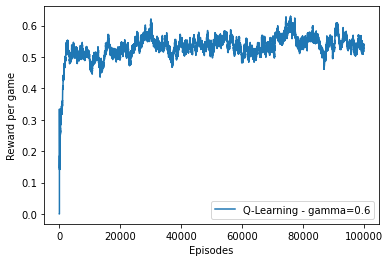

In [7]:
# Reward per game using an exponential average with 500 decay.
R_ma_q = pd.DataFrame({'R': R_save_q}).ewm(com=400).mean()

plt.plot(R_ma_q, label="Q-Learning - gamma=0.6")
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Reward per game")
plt.savefig(f"q_rewards_{N_episodes}_gamma_06.pdf")

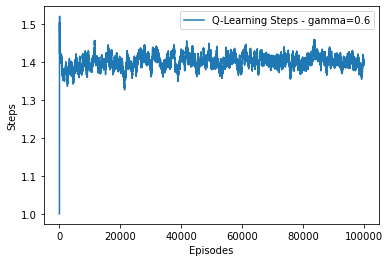

In [8]:
# Reward per game using an exponential average with 500 decay.
N_ma_q = pd.DataFrame({'N': N_moves_save_q}).ewm(com=400).mean()
plt.plot(N_ma_q, label="Q-Learning Steps - gamma=0.6")
plt.xlabel("Episodes")
plt.ylabel("Steps")
plt.legend()
plt.savefig(f"q_steps_{N_episodes}_gamma_06.pdf")